In [2]:
import nest_asyncio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.ndimage import gaussian_filter1d
from tastytrade import Account, Session, DXLinkStreamer
from tastytrade.dxfeed import Quote, Candle
from tastytrade.instruments import *
from tastytrade.market_data import *
import yfinance as yf
from itertools import chain
from config import *
from alphas import *
from auxiliary import *
from datetime import datetime, timedelta, time
import asyncio
import requests
import logging
import json
from zoneinfo import ZoneInfo
nest_asyncio.apply()

session=None
account=None

async def setup():
    global session, account, config
    # setup
    config = Config(test=False)
    session = Session(config.username, config.password, is_test=config.test)
    account = await Account.a_get(session, config.account_number)

    # account info
    balance = account.get_balances(session)
    positions = account.get_positions(session)
    history = account.get_history(session)

asyncio.run(setup())
print("Session and account setup complete.")

streamer = DXLinkStreamer(session) #async streamer

nytime = datetime.now(ZoneInfo("America/New_York"))

Session and account setup complete.


In [8]:
SPXoptionchain = get_option_chain(session, "SPX")
VIXoptionchain = get_option_chain(session, "VIX")

SPXexpiries = list(SPXoptionchain.keys())
VIXexpiries = list(VIXoptionchain.keys())

SPXdata = get_market_data_by_type(session,indices = ['SPX'])
VIXdata = get_market_data_by_type(session,indices = ['VIX'])
print(SPXdata)

[MarketData(symbol='SPX' instrument_type=<InstrumentType.INDEX: 'Index'> updated_at=datetime.datetime(2025, 6, 18, 20, 59, 49, 864000, tzinfo=TzInfo(UTC)) mark=Decimal('5979.56') close_price_type=<ClosePriceType.REGULAR: 'Regular'> summary_date=datetime.date(2025, 6, 18) prev_close_date=datetime.date(2025, 6, 17) prev_close_price_type=<ClosePriceType.REGULAR: 'Regular'> halt_start_time=-1 halt_end_time=-1 ask=Decimal('6027.69') beta=Decimal('1.0') bid=Decimal('5931.43') day_high_price=Decimal('6018.25') day_low_price=Decimal('5971.89') last=Decimal('5980.87') last_mkt=Decimal('5980.87') mid=Decimal('5979.56') open=Decimal('5987.93') prev_close=Decimal('5982.72') year_low_price=Decimal('4835.04') year_high_price=Decimal('6147.43'))]


In [ ]:
date.today()

In [ ]:
first5=SPXexpiries[:5]
sd=first5[-1]+timedelta(days=1)
def ldm(d): nd=datetime(d.year+1,1,1) if d.month==12 else datetime(d.year,d.month+1,1); return nd-timedelta(days=1)
eoms=[d for d in SPXexpiries if d>=sd and d.day==ldm(d).day][:6]
SPXsavelist=first5+eoms
VIXsavelist=VIXexpiries[:10]

In [9]:
from curl_cffi import requests as yfrequests
yfsession = yfrequests.Session(impersonate="safari")
SPXspot = SPXdata[0].last
VIXspot = VIXdata[0].last
try:
    treasury_bill = yf.Ticker("^IRX")#, session=yfsession)
    hist = treasury_bill.history(period="1d")
    rfr = float(hist['Close'].iloc[-1])
except Exception as e:
    rfr = 4.5

In [2]:
yf.download("NVDA", period="1d", interval="1d")

C:\Users\warre\AppData\Local\Temp\ipykernel_56032\1121495506.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf.download("NVDA", period="1d", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2025-06-17,144.119995,145.220001,143.779999,144.490005,138340800


In [ ]:
payload = {
    "SPX": {"spot": SPXspot},
    "VIX": {"spot": VIXspot}
}

for exp in SPXsavelist:
    payload["SPX"][exp.isoformat()] = {
        "optionchain": OptionMethods.convertchain(session, SPXoptionchain[exp])
    }

for exp in VIXsavelist:
    payload["VIX"][exp.isoformat()] = {
        "optionchain": OptionMethods.convertchain(session, VIXoptionchain[exp])
    }

snapshot = {
    "date": date.today().isoformat(),
    "period": "AM" if datetime.now().time() < time(12, 0) else "PM",
    "fetchtime": datetime.now().isoformat(),
    "rfr": 4.5,
    "payload": payload
}

In [ ]:
zerodte = SPXexpiries[0]
zerodtechain = OptionMethods.convertchain(session, SPXoptionchain[zerodte])

In [2]:
PROJECT_URL = config.database_url
API_KEY = config.database_anon_key
TABLE_NAME = "market_snapshots"

headers = {
    "apikey": API_KEY,
    "Authorization": f"Bearer {API_KEY}"
}

params = {
    "date": "in.(2025-06-17,2025-06-18)",
    "period": "eq.AM"
}

url = f"{PROJECT_URL}/rest/v1/{TABLE_NAME}"

response = requests.get(url, headers=headers, params=params)
data = response.json()

In [27]:
exps = [exp for exp in list(data[0]['payload']["SPX"].keys()) if exp != "spot"]

In [4]:
spxchain1 = data[0]['payload']["SPX"]["optionchain"]["2025-06-17"]
spxoptions1 = pd.DataFrame.from_dict(spxchain1)
atmfs1 = OptionMethods.find_atmf_strike(spxoptions1)
spxchain2 = data[1]['payload']["SPX"]["optionchain"]["2025-06-18"]
spxoptions2 = pd.DataFrame.from_dict(spxchain2)
atmfs2 = OptionMethods.find_atmf_strike(spxoptions2)

AttributeError: type object 'OptionMethods' has no attribute 'find_atmf_strike'

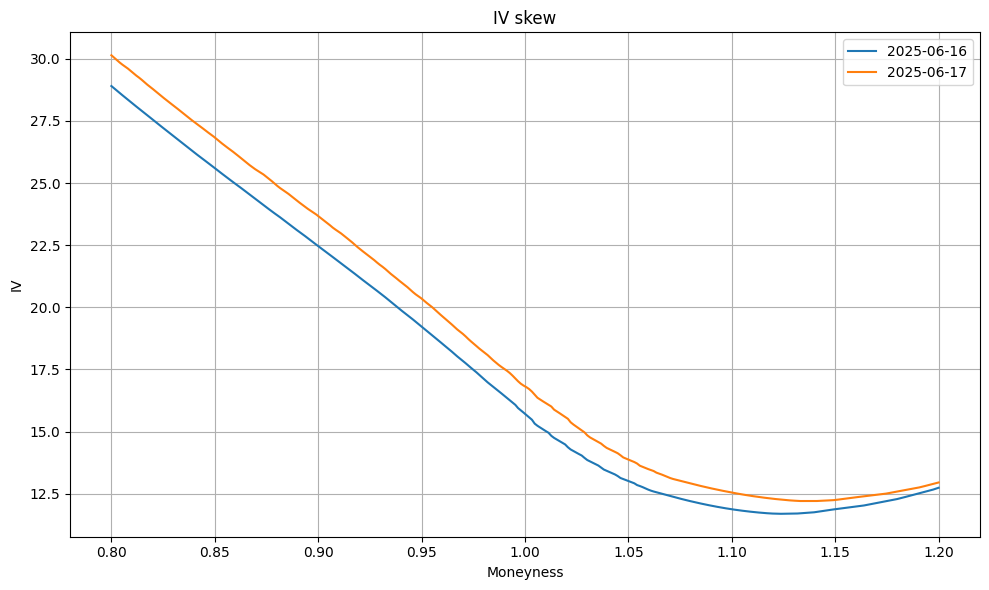

In [33]:
def bs_price_fwd(option, F, K, T, r, sigma):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    df = np.exp(-r * T)
    if option == 'c':
        return df * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        return df * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

def add_iv_to_chain(date, df: pd.DataFrame, rfr: float) -> pd.DataFrame:
    if date == '2025-06-16':
        T = (pd.to_datetime("2025-09-30") - pd.to_datetime("2025-06-16")).days / 365
    elif date == '2025-06-17':
        T = (pd.to_datetime("2025-09-30") - pd.to_datetime("2025-06-17")).days / 365
    else:
        raise ValueError("Unsupported DataFrame provided")
    df = df.copy()
    df['cmid'] = (df['cbid'] + df['cask']) / 2
    df['pmid'] = (df['pbid'] + df['pask']) / 2

    F0 = OptionMethods.find_atmf_strike(df)
    #T = 1 / 252
    ivs = []

    for _, row in df.iterrows():
        K = row['strike']
        if K >= F0:
            price = row['cmid']
            opt_type = 'c'
        else:
            price = row['pmid']
            opt_type = 'p'

        def obj_fn(sigma):
            return bs_price_fwd(opt_type, F0, K, T, rfr, sigma) - price

        try:
            iv_val = brentq(obj_fn, 1e-6, 5.0)
        except ValueError:
            iv_val = np.nan

        ivs.append(iv_val)

    df['iv'] = ivs
    return df

rfr = 4.218/100
df1_iv = add_iv_to_chain('2025-06-16', spxoptions1, rfr)
df2_iv = add_iv_to_chain('2025-06-17', spxoptions2, rfr)
for df in [df1_iv, df2_iv]:
    df['iv'] *= 100
    atmf = OptionMethods.find_atmf_strike(df)
    df['strike'] /= atmf
    df['iv'] = gaussian_filter1d(df['iv'], sigma=2, mode='nearest')
common_strikes = np.linspace(0.8, 1.2, 300)
df1_interp = np.interp(common_strikes, df1_iv['strike'], df1_iv['iv'])
df2_interp = np.interp(common_strikes, df2_iv['strike'], df2_iv['iv'])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(common_strikes, df1_interp, label='2025-06-16')
plt.plot(common_strikes, df2_interp, label='2025-06-17')
plt.title('IV skew')
plt.xlabel('Moneyness')
plt.ylabel('IV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Forward for 2025-06-18: 5985.00
Forward for 2025-06-20: 5985.00
Forward for 2025-06-23: 5985.00
Forward for 2025-06-24: 5990.00
Forward for 2025-06-30: 5990.00
Forward for 2025-07-31: 6010.00
Forward for 2025-09-30: 6045.00
Forward for 2025-10-31: 6070.00
Forward for 2025-12-31: 6100.00
Forward for 2026-03-31: 6150.00


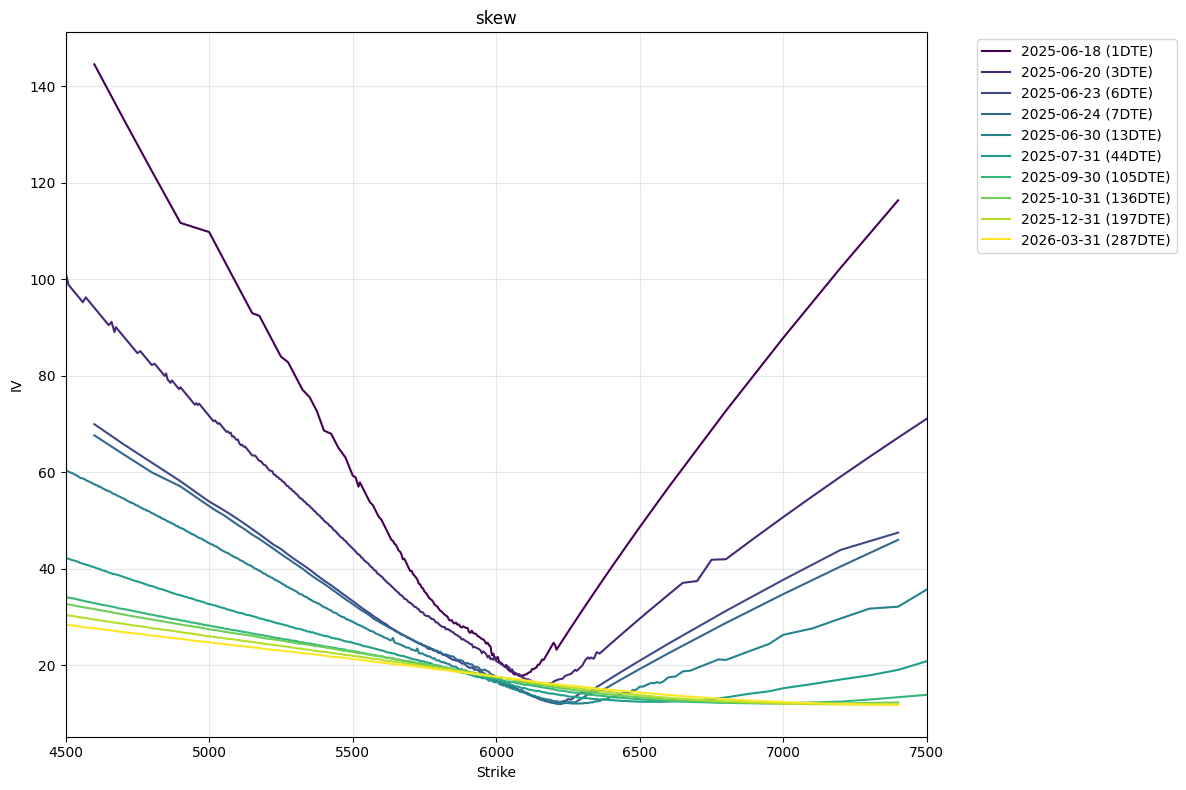

Summary of processed expiries:
2025-06-18 (1DTE): 193 valid IVs, IV range: 17.8% - 473.1%
2025-06-20 (3DTE): 468 valid IVs, IV range: 16.1% - 474.4%
2025-06-23 (6DTE): 183 valid IVs, IV range: 12.2% - 193.1%
2025-06-24 (7DTE): 166 valid IVs, IV range: 12.0% - 178.9%
2025-06-30 (13DTE): 471 valid IVs, IV range: 12.1% - 228.0%
2025-07-31 (44DTE): 415 valid IVs, IV range: 12.4% - 120.6%
2025-09-30 (105DTE): 393 valid IVs, IV range: 12.1% - 97.0%
2025-10-31 (136DTE): 169 valid IVs, IV range: 12.1% - 67.4%
2025-12-31 (197DTE): 247 valid IVs, IV range: 11.9% - 79.2%
2026-03-31 (287DTE): 131 valid IVs, IV range: 11.8% - 53.1%


In [26]:
# --- Inputs (to be provided) ---
# data: nested dictionary with structure data[0]['payload']['SPX'][exp]['optionchain']
# find_atmf_strike: function to calculate forward level for each expiry
# rfr: annualized risk-free rate (decimal)
# exps: list of expiry dates
# --------------------------------

# Set today's date
today = pd.to_datetime('2025-06-17')
exps = [exp for exp in list(data[1]['payload']["SPX"]["optionchain"].keys()) if exp != "spot"]
# Filter expiries from 2015-06-17 onwards (exclude 2015-06-16)
valid_exps = [exp for exp in exps if exp != "2015-06-17"]

# Black-Scholes pricing function using forward measure
def bs_price_fwd(option, F, K, T, r, sigma):
    """Black-Scholes price using forward measure"""
    if T <= 0 or sigma <= 0:
        return 0

    d1 = (np.log(F/K) + 0.5*sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    df = np.exp(-r*T)

    if option == 'c':
        return df * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:  # put
        return df * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

# Store results for each expiry
results = {}
r = rfr/100

# Process each expiry
for exp in valid_exps:
    # Calculate time to expiry in years
    exp_date = pd.to_datetime(exp)
    T_exp = (exp_date - today).days / 365.25

    if T_exp <= 0:
        continue

    # Get options data for this expiry from nested structure
    try:
        spxchain_exp = data[1]['payload']['SPX']['optionchain'][exp]
        spx_exp = pd.DataFrame.from_dict(spxchain_exp)
    except (KeyError, IndexError):
        print(f"No option chain found for expiry: {exp}")
        continue

    if len(spx_exp) == 0:
        continue

    # Get forward level for this expiry using OptionMethods.find_atmf_strike function
    try:
        exp_forward = OptionMethods.find_atmf_strike(spx_exp)
        print(f"Forward for {exp}: {exp_forward:.2f}")
    except Exception as e:
        print(f"Could not calculate forward for expiry {exp}: {e}")
        continue

    # Prepare mid prices
    spx_exp['cmid'] = (spx_exp['cask'] + spx_exp['cbid']) / 2
    spx_exp['pmid'] = (spx_exp['pask'] + spx_exp['pbid']) / 2

    # Sort by strike
    spx_sorted_exp = spx_exp.sort_values('strike').reset_index(drop=True)

    # Calculate implied volatilities with better error handling
    iv_list = []
    for idx, row in spx_sorted_exp.iterrows():
        K_i = row['strike']
        # Use calls for strikes >= forward, puts for strikes < forward
        price = row['cmid'] if K_i >= exp_forward else row['pmid']
        option = 'c' if K_i >= exp_forward else 'p'

        # Skip if price is invalid
        if price <= 0 or np.isnan(price):
            iv_list.append(np.nan)
            continue

        # Check for intrinsic value violations
        if option == 'c':
            intrinsic = max(0, np.exp(-r*T_exp) * (exp_forward - K_i))
        else:
            intrinsic = max(0, np.exp(-r*T_exp) * (K_i - exp_forward))

        if price < intrinsic * 0.99:  # Allow small tolerance
            print(f"Skipping {option} K={K_i}: price={price:.4f} < intrinsic={intrinsic:.4f}")
            iv_list.append(np.nan)
            continue

        # Solve for implied volatility with better bounds and initial guess
        def objective(vol):
            return bs_price_fwd(option, exp_forward, K_i, T_exp, r, vol) - price

        try:
            # Try different initial guesses
            for initial_vol in [0.2, 0.1, 0.5, 1.0]:
                try:
                    iv_est = brentq(objective, 1e-6, 10.0)
                    if 0.01 <= iv_est <= 5.0:  # Reasonable IV range
                        break
                except:
                    continue
            else:
                iv_est = np.nan

        except Exception as e:
            iv_est = np.nan

        iv_list.append(iv_est)

    spx_sorted_exp['iv'] = np.array(iv_list)

    # Store results
    results[exp] = spx_sorted_exp.copy()

# Plot all skew curves together
plt.figure(figsize=(12, 8))

# Use viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(results)))

for i, (exp, data_exp) in enumerate(results.items()):
    # Filter strikes between 4500 and 7500
    mask = (data_exp['strike'] >= 4500) & (data_exp['strike'] <= 7500) & (~np.isnan(data_exp['iv']))

    if mask.sum() > 0:
        strikes_filtered = data_exp.loc[mask, 'strike']
        ivs_filtered = data_exp.loc[mask, 'iv'] * 100  # Convert to percentage

        # Calculate days to expiry for legend
        exp_date = pd.to_datetime(exp)
        dte = (exp_date - today).days

        plt.plot(strikes_filtered, ivs_filtered,
                color=colors[i], linewidth=1.5,
                label=f'{exp} ({dte}DTE)')

plt.title('skew')
plt.xlabel('Strike')
plt.ylabel('IV')
plt.xlim(4500, 7500)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of processed expiries:")
for exp, data_exp in results.items():
    exp_date = pd.to_datetime(exp)
    dte = (exp_date - today).days
    valid_ivs = data_exp['iv'].dropna()
    print(f"{exp} ({dte}DTE): {len(valid_ivs)} valid IVs, "
          f"IV range: {valid_ivs.min()*100:.1f}% - {valid_ivs.max()*100:.1f}%")

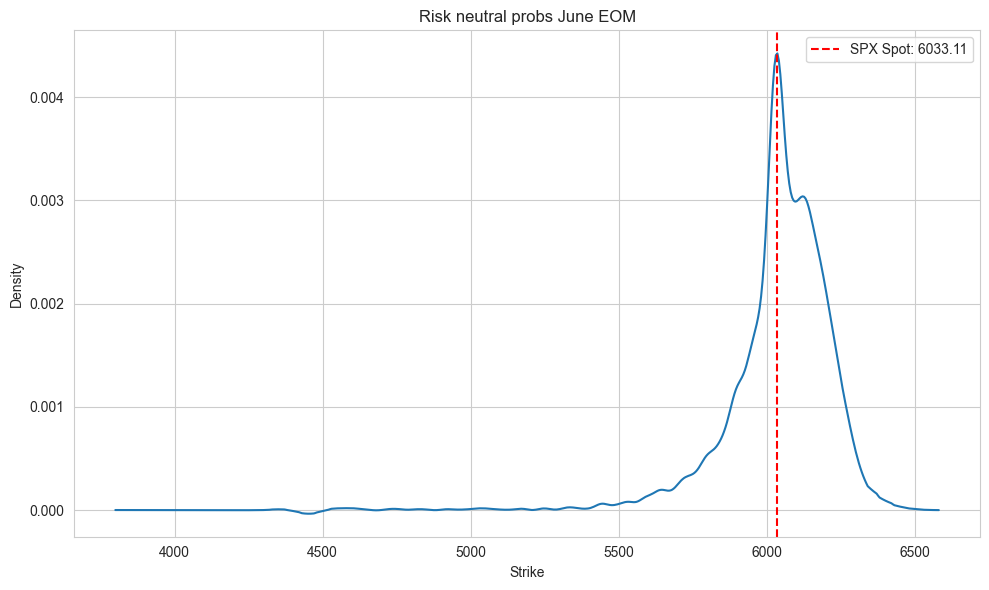

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Assume `data`, `OptionMethods`, `rfr`, and `SPXspot` are defined
# Load SPX options chain for expiry
spxchain = data[0]['payload']["SPX"]["2025-06-30"]["optionchain"]
spx = pd.DataFrame.from_dict(spxchain)

# Find at-the-money forward strike
atmfs = OptionMethods.find_atmf_strike(spx)

# Prepare data
spx = spx.sort_values("strike").reset_index(drop=True)
spx['cmid'] = (spx['cbid'] + spx['cask']) / 2
spx['pmid'] = (spx['pbid'] + spx['pask']) / 2

# Time to expiry: 14 calendar days
T = 14 / 365

# Extract arrays
K = spx['strike'].values
Cc = spx['cmid'].values  # call mid-prices
Cp = spx['pmid'].values  # put mid-prices

# Locate ATM index (closest strike to forward)
#atm_idx = np.abs(K - atmfs).argmin()

# Compute second derivative with consistent region usage
N = len(K)
d2C = np.full(N, np.nan)
for i in range(1, N-1):
    dk_fwd = K[i+1] - K[i]
    dk_bwd = K[i]   - K[i-1]
    if K[i] >= SPXspot:
        # strikes at or above ATM: use call mids
        delta_fwd = (Cc[i+1] - Cc[i]) / dk_fwd
        delta_bwd = (Cc[i]   - Cc[i-1]) / dk_bwd
    else:
        # strikes below ATM: use put mids
        delta_fwd = (Cp[i+1] - Cp[i]) / dk_fwd
        delta_bwd = (Cp[i]   - Cp[i-1]) / dk_bwd
    d2C[i] = 2 * (delta_fwd - delta_bwd) / (dk_fwd + dk_bwd)

# Smooth second derivative
d2C_smooth = gaussian_filter1d(d2C, sigma=5, mode='nearest')

# Compute risk-neutral density: f(K) = exp(rfr * T) * d²C/dK²
f_K = np.exp(rfr/100 * T) * d2C_smooth
spx['density'] = f_K

# Plot
plt.figure(figsize=(10, 6))
plt.plot(spx['strike'], spx['density'], lw=1.5)
plt.axvline(SPXspot, color='red', linestyle='--', label=f'SPX Spot: {SPXspot}')
plt.title('Risk neutral probs June EOM')
plt.xlabel('Strike')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
spxchainf = data[0]['payload']["SPX"]["optionchain"]["2026-03-31"]
spxoptionsf = pd.DataFrame.from_dict(spxchainf)
atmfsf = OptionMethods.find_atmf_strike(spxoptionsf)

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
from auxiliary import *

# Black‑76 (forward) price for a call

def bs76_call(F, K, T, sigma, rfr):
    if sigma <= 0 or T <= 0:
        return max(F - K, 0.0) * np.exp(-rfr * T)
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return np.exp(-rfr * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))

# Black‑76 (forward) price for a put

def bs76_put(F, K, T, sigma, rfr):
    if sigma <= 0 or T <= 0:
        return max(K - F, 0.0) * np.exp(-rfr * T)
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return np.exp(-rfr * T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

# Implied volatility solver under Black‑76

def implied_volatility_forward(price, F, K, T, rfr, is_call=True):
    if price < 1e-8 or T <= 0:
        return 0.0

    def objective(sigma):
        if is_call:
            return bs76_call(F, K, T, sigma, rfr) - price
        else:
            return bs76_put(F, K, T, sigma, rfr) - price

    try:
        iv = brentq(objective, 1e-6, 5.0, maxiter=500)
    except ValueError:
        iv = 0.0
    return iv * 100  # percentage points

# Main function with forward calibrated by ATMF

def add_mids_and_ivs(
    df: pd.DataFrame,
    spot: float,
    dte_days: float,
    rfr: float,
    q: float = 0.0
) -> pd.DataFrame:
    """
    df must have columns: cbid, cask, pbid, pask, strike
    spot = current spot price
    dte_days = days to expiry
    rfr = continuous risk‑free rate
    q   = continuous dividend yield
    OptionMetrics.find_atmf_strike(df) returns the ATM forward strike
    """
    df = df.copy()
    rfr = rfr/100
    T = dte_days / 365.0

    # mid‑prices
    df['cmid'] = (df['cbid'] + df['cask']) / 2
    df['pmid'] = (df['pbid'] + df['pask']) / 2

    # 1) calibrate forward via ATMF strike
    K_atm = OptionMethods.find_atmf_strike(df)
    atm_row = df.loc[df['strike'] == K_atm].iloc[0]
    cmid_atm, pmid_atm = atm_row['cmid'], atm_row['pmid']
    F = K_atm + np.exp((rfr-q) * T) * (cmid_atm - pmid_atm)

    # compute IVs
    civ_list, piv_list = [], []
    for _, row in df.iterrows():
        K = row['strike']
        civ = implied_volatility_forward(row['cmid'], F, K, T, rfr, is_call=True)
        piv = implied_volatility_forward(row['pmid'], F, K, T, rfr, is_call=False)
        civ_list.append(civ)
        piv_list.append(piv)

    df['civ'] = civ_list
    df['piv'] = piv_list
    return df



fdf = add_mids_and_ivs(spxoptionsf, SPXspot, (pd.to_datetime("2026-03-31") - pd.to_datetime("2025-06-17")).days, rfr, q=0.018)  # Example with 30 DTE

In [139]:
(pd.to_datetime("2026-03-31") - pd.to_datetime("2025-06-16")).days  # Check DTE calculation

288

In [3]:
CRCLoptionchain = get_option_chain(session, "CRCL")
CRCLexpiries = list(CRCLoptionchain.keys())
CRCLclosest = OptionMethods.convertchain(session, CRCLoptionchain[CRCLexpiries[0]])

In [7]:
CRCLchain = OptionMethods.find_ivs(CRCLclosest, 1.5, 4.2,0,2)

198.99982738236358


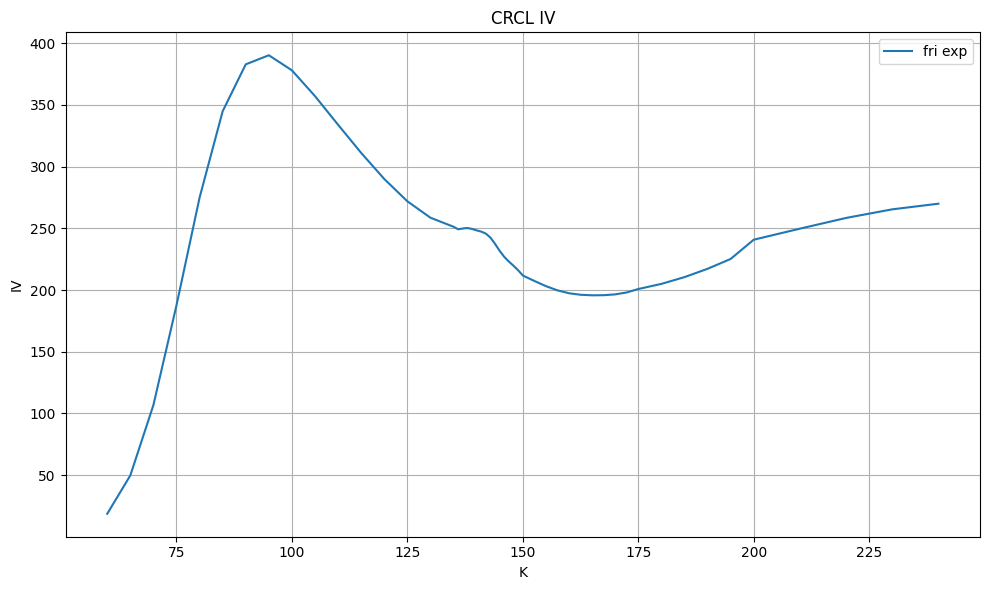

In [8]:
df = CRCLchain.copy()
atmfs = OptionMethods.find_atmf_strike(df)
df['iv'] = np.where(df['strike'] >= atmfs, df['civ'], df['piv'])
plt.figure(figsize=(10, 6))
plt.plot(df['strike'], df['iv'], label='fri exp')
plt.title('CRCL IV')
plt.xlabel('K')
plt.ylabel('IV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()